In [222]:
#Importo las librerias a usar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates 
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from plotly.offline import iplot



In [223]:
from sklearn.ensemble import RandomForestRegressor # Random forests para decisión

# Módulos utiles para evaluar el modelo 
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

Exploramos y limpiamos los datos

Cargamos los datos y luego de un analisis exploratorio vemos (aunque ya lo sabiamos) que hay varias columnas con NANs. Las completamos con 0.
Cambiamos el tipo de algunos datos a float.
Cambiamos la fecha a datetime.

Queremos formatear los datos para poder predecir mejor si va a comprar o no

In [224]:
fileName = 'data.csv'
data = pd.read_csv(fileName, sep = ",")

data.isnull().sum()

/tmp/ipykernel_92204/2627187492.py:2: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



fullVisitorID              0
visitNumber                0
date                       0
bounces               196928
hits                       0
pageviews                 36
timeOnSite            196493
transactionRevenue    387615
transactions          387615
source                     0
channelGrouping            0
browser                    0
deviceCategory             0
country                    0
city                       0
dtype: int64

In [225]:
#Me fijo que columnas tienen missing values y los completo con 0
data.fillna({'bounces' : 0,'timeOnSite':0, 'transactionRevenue':0,'transactions':0, "pageViews":0}, inplace=True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorID       392892 non-null  object 
 1   visitNumber         392892 non-null  int64  
 2   date                392892 non-null  int64  
 3   bounces             392892 non-null  float64
 4   hits                392892 non-null  int64  
 5   pageviews           392856 non-null  float64
 6   timeOnSite          392892 non-null  float64
 7   transactionRevenue  392892 non-null  float64
 8   transactions        392892 non-null  float64
 9   source              392892 non-null  object 
 10  channelGrouping     392892 non-null  object 
 11  browser             392892 non-null  object 
 12  deviceCategory      392892 non-null  object 
 13  country             392892 non-null  object 
 14  city                392892 non-null  object 
dtypes: float64(5), int64(3), object(7)

In [226]:
#Me interesa si un dado visitor convirtio (es decir, realizo una transaccion) o no. Creo una columna de booleanos (1 o 0) que me indique si convirtio (1) o no (0)

data['conversionBool'] = np.where(data['transactions'] > 0, 1, 0)
data['hitBool'] = np.where(data['hits'] > 1, 1, 0)

In [227]:
#Preprocesamiento de los datos para que esten en el formato requerido

data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
data['transactionRevenue'] = data['transactionRevenue'].astype('float')
data['transactions'] = data['transactions'].astype('float')
data['fullVisitorID'] = data['fullVisitorID'].astype('string') #Por si el ID empezara en 0 

In [248]:
data['Month'] = data['date'].dt.to_period('M')
data['cohort'] = data.groupby('fullVisitorID')['date'].transform('min').dt.to_period('M')
data['login_date'] = data.groupby('fullVisitorID')['date'].transform('min')
data['timeSinceLogin'] = data['date'] - data['login_date'] 

".dt.to_period('D')"

In [249]:
data['totalvisitorRevenue'] = data.groupby('fullVisitorID')['transactionRevenue'].transform('sum') #Calculo el gasto total de cada cliente

In [229]:
print('Total records: ', len(data), 'customers doesnt contribute for revenue: ',data['transactionRevenue'].isna().sum())

Total records:  392892 customers doesnt contribute for revenue:  0


In [254]:
data.head()

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,...,country,city,conversionBool,hitBool,totalvisitorRevenue,login_month,cohort,Month,login_date,timeSinceLogin
0,8533875475515924645,1,2017-02-05,1.0,1,1.0,0.0,0.0,0.0,(direct),...,Australia,Sydney,0,0,0.0,2017-02,2017-02,2017-02,2017-02-05,0 days
1,4874599869430831185,2,2017-02-05,1.0,1,1.0,0.0,0.0,0.0,(direct),...,Turkey,Istanbul,0,0,0.0,2017-02,2017-02,2017-02,2017-02-05,0 days
2,361954421372951638,1,2017-02-05,1.0,1,1.0,0.0,0.0,0.0,(direct),...,Russia,Moscow,0,0,0.0,2017-02,2017-02,2017-02,2017-02-05,0 days
3,8751850432978942600,2,2017-02-05,1.0,1,1.0,0.0,0.0,0.0,bing,...,United States,not available in demo dataset,0,0,0.0,2017-02,2017-02,2017-02,2017-02-05,0 days
4,2451058030378352110,1,2017-02-05,1.0,1,1.0,0.0,0.0,0.0,(direct),...,Indonesia,not available in demo dataset,0,0,0.0,2017-02,2017-02,2017-02,2017-02-05,0 days


In [255]:
a = data.groupby('fullVisitorID').agg({'visitNumber': 'sum', 'bounces': 'mean', 'pageviews':'mean','transactionRevenue': 'max'})

In [256]:
a

,visitNumber,bounces,pageviews,transactionRevenue
fullVisitorID,,,,
0000027376579751715,1,0.0,5.0,0.00
0000040862739425590,3,0.0,2.5,0.00
0000068403966359845,1,0.0,2.0,0.00
0000213131142648941,1,0.0,13.0,39.59
0000291342601222013,1,0.0,3.0,0.00
...,...,...,...,...
9999955365228667450,1,0.0,2.0,0.00
9999963186378918199,1,1.0,1.0,0.00
999997550040396460,3,0.5,1.5,0.00


In [253]:
prueba

agg({'pred_x': ['mean', 'count', 'std'], 'pred_y': ['mean', 'count', 'std']

,0,1
0,0000027376579751715,fullVisitorID visitNumber ...
1,0000040862739425590,fullVisitorID visitNumber ...
2,0000068403966359845,fullVisitorID visitNumber ...
3,0000213131142648941,fullVisitorID visitNumber ...
4,0000291342601222013,fullVisitorID visitNumber ...
...,...,...
309707,9999955365228667450,fullVisitorID visitNumber ...
309708,9999963186378918199,fullVisitorID visitNumber ...
309709,999997550040396460,fullVisitorID visitNumber ...
309710,9999978264901065827,fullVisitorID visitNumber ...


In [230]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
visitNumber,392892.0,2.361198,10.158865,1.0,1.0,1.0,1.0,389.00
bounces,392892.0,0.498773,0.499999,0.0,0.0,0.0,1.0,1.00
hits,392892.0,4.414065,8.555069,1.0,1.0,2.0,4.0,500.00
pageviews,392856.0,3.771015,6.414908,1.0,1.0,1.0,4.0,466.00
timeOnSite,392892.0,138.385447,370.290633,0.0,0.0,0.0,94.0,12136.00
transactionRevenue,392892.0,2.187108,105.837010,0.0,0.0,0.0,0.0,47082.06
transactions,392892.0,0.014073,0.137584,0.0,0.0,0.0,0.0,25.00
conversionBool,392892.0,0.013431,0.115112,0.0,0.0,0.0,0.0,1.00
hitBool,392892.0,0.505477,0.499971,0.0,0.0,1.0,1.0,1.00
totalvisitorRevenue,392892.0,54.262456,2384.658527,0.0,0.0,0.0,0.0,128412.52


Algunos graficos

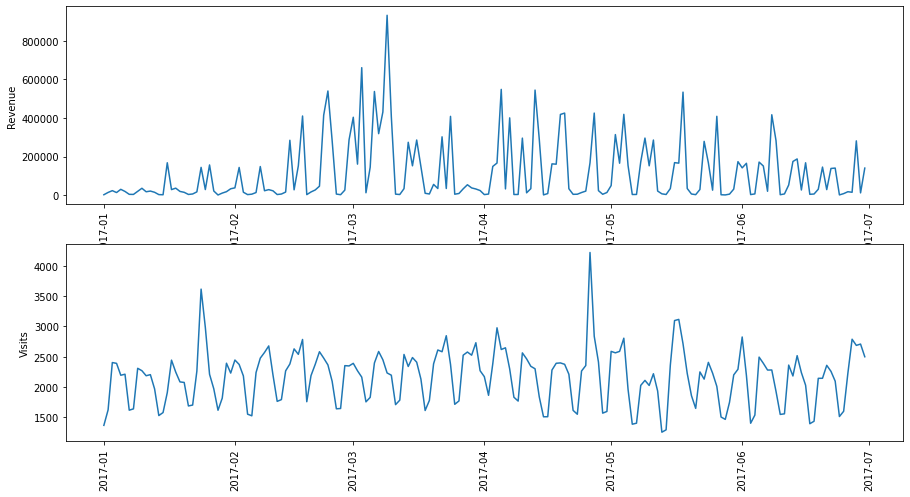

In [231]:
plot_df = data.groupby(by=['date']).agg({'fullVisitorID':'count','totalvisitorRevenue':'sum'}).reset_index()

fig = plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(pd.to_datetime(plot_df['date']),plot_df['totalvisitorRevenue'])
plt.ylabel('Revenue')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.plot(pd.to_datetime(plot_df['date']),plot_df['fullVisitorID'])
plt.ylabel('Visits')
plt.xticks(rotation=90);

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

<AxesSubplot:>

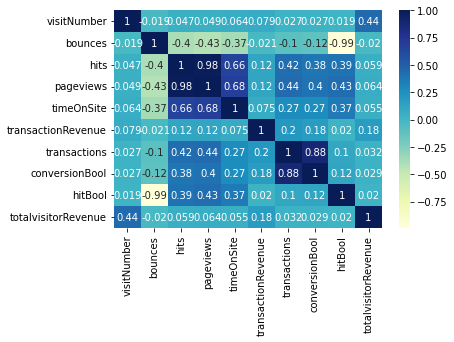

In [232]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [233]:
""" for i, col in enumerate(['channelGrouping']):
    plt.figure(i)
    sns.catplot(x=col, y='transactions', data=data, kind='point', aspect=2,)
    plt.xlim(0,6) """

" for i, col in enumerate(['channelGrouping']):\n    plt.figure(i)\n    sns.catplot(x=col, y='transactions', data=data, kind='point', aspect=2,)\n    plt.xlim(0,6) "

Analisis por cohortes

In [235]:
df_cohort = data.groupby(['cohort', 'Month']).agg(n_customers=('fullVisitorID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.Month - df_cohort.cohort).apply(attrgetter('n'))

df_cohort

,cohort,login_month,n_customers,period_number
0,2017-01,2017-01,53280,0
1,2017-01,2017-02,2127,1
2,2017-01,2017-03,904,2
3,2017-01,2017-04,564,3
4,2017-01,2017-05,411,4
5,2017-01,2017-06,277,5
6,2017-02,2017-02,49467,0
7,2017-02,2017-03,1680,1
8,2017-02,2017-04,537,2
9,2017-02,2017-05,387,3


In [236]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [237]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

retention_matrix

period_number,0,1,2,3,4,5
cohort,,,,,,
2017-01,1.0,0.039921,0.016967,0.010586,0.007714,0.005199
2017-02,1.0,0.033962,0.010856,0.007823,0.004326,NaN
2017-03,1.0,0.030707,0.010872,0.005220,NaN,NaN
2017-04,1.0,0.034212,0.010349,NaN,NaN,NaN
2017-05,1.0,0.036821,NaN,NaN,NaN,NaN
2017-06,1.0,NaN,NaN,NaN,NaN,NaN


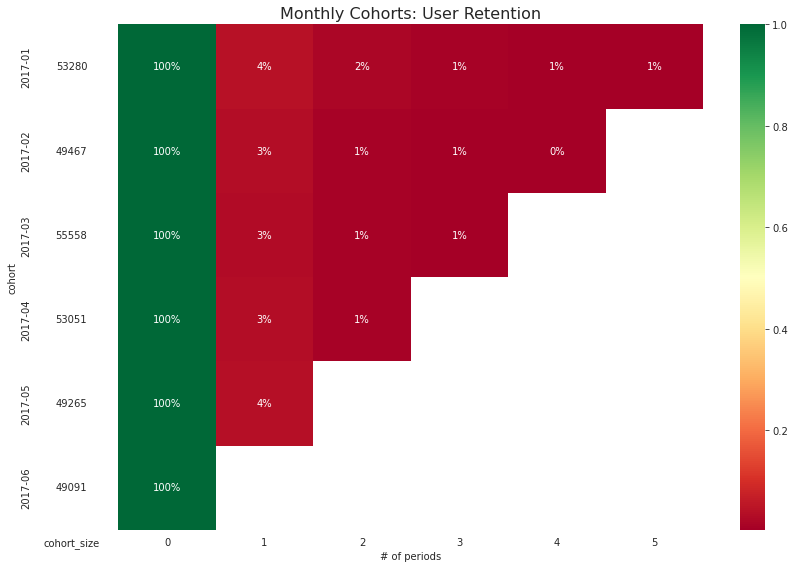

In [238]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [239]:
channels = list(data['channelGrouping'].unique())
datos = []
for channel in channels:
    subset = data[data['channelGrouping']==channel]
    subset = subset.groupby('date')['transactionRevenue'].agg(['sum'])
    subset.columns = ["Total"]
    subset = subset.sort_index()
    trace = go.Scatter(
        x = subset['Total'].index,
        y = subset['Total'].values,
        name=channel,
        mode='lines'
    )
    datos.append(trace)
layout= go.Layout(
    title= 'Total amount of non-zero transactions per day, grouped by channel',
    xaxis = dict(title = 'Date'), yaxis = dict(title = 'Total'),
    showlegend=True,
)
fig = dict(data=datos, layout=layout)
iplot(fig, filename='lines')

In [240]:
def plotmap(frame, z_var, countries_col, title, colorscale, rcolor=True):

    dato = [ dict(
            type = 'choropleth',
            autocolorscale = False,
            colorscale = colorscale,
            showscale = True,
            reversescale = rcolor,
            locations = frame[countries_col],
            z = frame[z_var],
            locationmode = 'country names',
            text = frame[countries_col],
            marker = dict(line = dict(color = '#fff', width = 2))
        )           
    ]

    layout = dict(
        height=680,
        width=1200,
        title = title,
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(type = 'mercator'),
        ),
    )
    fig = dict(data=dato, layout=layout)
    iplot(fig)

colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]
    
# Plot world map - total visits
tmp = data["country"].value_counts().to_frame().reset_index()
plotmap(tmp, 'country', 'index', 'Total visits by Country', colorscale, False)

colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]]

Modelo
1. Separamos los datos en train\test\validation
2. Fiteamos y evaluamos un modelo
3. Tuneamos los hiperparametros
4. Evaluamos en el set de validacion
5. Evaluamos el modelo final en el test set

In [241]:
data.columns

Index(['fullVisitorID', 'visitNumber', 'date', 'bounces', 'hits', 'pageviews',
       'timeOnSite', 'transactionRevenue', 'transactions', 'source',
       'channelGrouping', 'browser', 'deviceCategory', 'country', 'city',
       'conversionBool', 'hitBool', 'totalvisitorRevenue', 'login_month',
       'cohort'],
      dtype='object')

Me fijo que columnas tienen valores unicos para encodear

In [242]:
unique_vals = data.nunique().sort_values(ascending = False)
unique_vals = unique_vals.to_frame()
unique_vals = unique_vals.reset_index()
unique_vals.columns = ['column', 'cnt']

dtypes = data.dtypes.to_frame()
dtypes = dtypes.reset_index()
dtypes.columns = ['column', 'type']

profile = pd.merge(unique_vals,dtypes,on = 'column',how = 'inner')
profile

,column,cnt,type
0,fullVisitorID,309712,string
1,timeOnSite,3500,float64
2,transactionRevenue,3119,float64
3,totalvisitorRevenue,2832,float64
4,city,416,object
5,visitNumber,376,int64
6,country,213,object
7,source,210,object
8,hits,198,int64
9,date,181,datetime64[ns]
